# Average Consensus

## Background the problem setting

Find $\bar{x} = \sum(x_i)$ for all agent $i$ defined over graph.
Application example? Page-rank? Markov-chain?


## Graph Definition

Talk about 
- graph definition $\mathcal{G} = (V,E)$
- directional and undirectional graph
- incoming neighbors and outgoing neighbors
- Stochastic matrix

BlueFog about

- `bf.set_topology()`
- Common topologies examples
- Weights and is_weighted Setting

## Communication over graph and Consensus algorithm

Algorithm:
- simply $x_{k+1} = W x_k$ iteration

BlueFog 
- `bf.neighbor_allreduce()`
- Collective communication -- BSP pattern (Bulk synchronized processing)

Analysis:
- Spectrum of Combination matrix $W$
- Convergence proof and speed discussion

In [1]:
import ipyparallel as ipp
import numpy as np
import torch
import networkx as nx   # nx will be used for network topology creating and plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
rc = ipp.Client(profile='bluefog')
rc.ids

[0, 1, 2, 3]

In [3]:
%%px
import numpy as np
import bluefog.torch as bf
import torch
from bluefog.common import topology_util
import networkx as nx

bf.init()
print(f"Hello, I am {bf.rank()} among {bf.size()} processes")

[stdout:0] Hello, I am 0 among 4 processes
[stdout:1] Hello, I am 1 among 4 processes
[stdout:2] Hello, I am 3 among 4 processes
[stdout:3] Hello, I am 2 among 4 processes


In [4]:
dview = rc[:] # A DirectView of all engines
dview.block=True

In [5]:
# Push the data into all workers
dview.push({'seed': 2021}, block=True)

[None, None, None, None]

In [6]:
%%px
print("I received seed as value: ", seed)

[stdout:0] I received seed as value:  2021
[stdout:1] I received seed as value:  2021
[stdout:2] I received seed as value:  2021
[stdout:3] I received seed as value:  2021


In [7]:
%%px 
# Generate parameters 
d = 10     # Dimension of parameter
x = torch.randn((d, 1))     # Randomly generate set of parameters.

In [8]:
d = dview.pull('d', block=True, targets=0)
x_sol = torch.zeros((d, 1))
for j in range(len(rc.ids)):
    x_sol += dview.pull('x', block=True, targets=j)     # Determine optimal solution.
x_sol /= len(rc.ids)
dview.push({'x_sol': x_sol})     # Push the optimal solution onto the workers.

[None, None, None, None]

A graph ($\mathcal{G} = (V,E)$) is a structure that contains a set of related objects. These objects are mathematically abstracted as vertices denoted as $V$. Pairs of related vertices are an edge denoted as $E$. If there are two related vertices $V_1$ and $V_2$, an edge would be defined as ($V_1$, $V_2$). A graph can be further classified as undirected or directed. In an undirected graph, edges indicate a two-way relationship meaning that each edge can be traversed in either direction. On the other hand, a directed graph has edges with direction meaning a one-way relationship. To explain the difference between an incoming neighbor and outgoing neighbor, we will use the notation for an edge defined before. An incoming neighbor is one that is on the receiving end of the traversal which for an edge ($V_1$, $V_2$) would be $V_2$. An outgoing neighbor is one that is at the beginning of the edge traversal which for an edge ($V_1$, $V_2$) would be $V_1$.

Graphs can be represented by an adjacency matrix $W$ of sixe $N \times N$ where $N$ is the number of vertices. A index of $W_{i, j}$ indicates that there is an edge between vertices $V_i$ and $V_j$. Some adjacency matrices have the special property of being stochastic. For a row-stochastic matrix, this means that the values in each row sum to 1. For a column-stochastic matrix, this means that the values in each column sum to one.

In the below code block, we generate an example graph that we will use to test the Consensus algorithm. The below graph is generated using the ExponentialTwoGraph() function provided. It takes as input the number of processes found using bf.size() and creates a graph with that many vertices such that each vertex connects to a point such that the index difference is the power of 2.

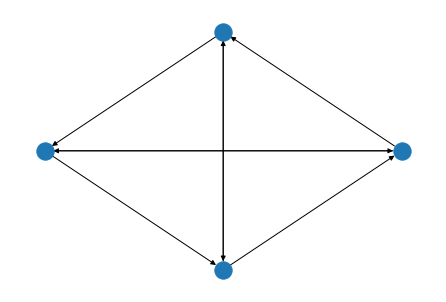

In [9]:
# Generate topology.

# Plot figure
%px G = topology_util.ExponentialTwoGraph(bf.size())

G_0 = dview.pull('G', block=True, targets=0)
nx.draw_circular(G_0)

We then use the set_topology() function to set the virtual topology MPI uses to graph we generated before. The load_toplogy() function then returns the virtual topology MSI is using. Afterwards, we use the GetRecvWeights() function to return the weight of the vertex itself as well as the weights of its neighbors.

In [10]:
%%px

# Set topology as exponential-2 graph.
bf.set_topology(G)
topology = bf.load_topology()
self_weight, neighbor_weights = topology_util.GetRecvWeights(topology, bf.rank())

In the following cell, we output the weight of one vertex and that of its neighbors. From this output, we can see that for the default graph we generated, a vertex gives itself and its neighbors equal weight.

In [11]:
%%px
if bf.rank() == 0:
    print('self weights: {}\n'.format(self_weight))
    print('neighbor weights:')
    for k, v in neighbor_weights.items():
        print(k, v)

[stdout:0] 
self weights: 0.3333333333333333

neighbor weights:
2 0.3333333333333333
3 0.3333333333333333


We now introduce the average consensus algorithm. The algorithm is extremely simple. Each vertex updates it parameters by taking a weighted average of its own set of parameters with its neighbors' parameters. Formally, the algorithm can be expressed as $x_{k+1} = W x_k$ where $x_k$ is the parameters from each neighbors and $W$ is a stochastic matrix as described before.

In [12]:
%%px 

def avg_consensus(x):
    x_new = bf.neighbor_allreduce(x, self_weight, neighbor_weights)
    return x_new, torch.norm(x_new-x_sol, p=2)

To implement the average consensus algorithm, we used the function neighbor_allreduce(). This is a function that performs weighted averaging of the input tensor over the neighbors and itself in the Bluefog processes. The default behavior is (uniformly) average. This function operates according to the BSP pattern (bulk synchronized processing). What this means is that each vertex has:

1) Local processing. \
2) Ability to communicate with its neighbors. \
3) A method to synchronize with is neighbors. 

In [13]:
%%px

maxite = 50

MSE = torch.zeros((maxite, 1))
for ite in range(maxite):
    
    if bf.rank()==0:
        if ite%100 == 0:
            print('Progress {}/{}'.format(ite, maxite))
        
    x, MSE[ite] = avg_consensus(x)

[stdout:0] Progress 0/50


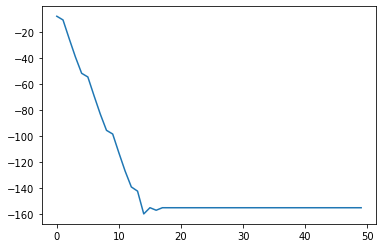

In [14]:
%px MSE = 10 * torch.log(MSE)
MSE = dview.pull('MSE', block=True, targets=0)
plt.plot(MSE)